In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from benji_transformer_play import *

scorer = Scorer2().to(device)
scorer.load_state_dict(torch.load('runs/colab_07_21-14_26_16/save_epoch29.pt', map_location=device))

data = datasets.load_dataset("universal_dependencies", "en_gum")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
val_data = [sequence for sequence in data['test'] if len(sequence['tokens']) < 20]
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True).to(device)

C:\Users\Buse\anaconda3\envs\afltproj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

Reusing dataset universal_dependencies (C:\Users\Buse\.cache\huggingface\datasets\universal_dependencies\en_gum\2.7.0\1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 115.40it/s]
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint o

In [3]:
length_sequence = 10 # we need this limit for the intersection not to get too big

In [4]:
val_short_data = [sequence for sequence in data['test'] if len(sequence['tokens']) < length_sequence]
len(data['test'])
len(val_data)
len(val_short_data)

890

540

256

In [5]:
val_short_data[:4]

[{'idx': 'GUM_academic_discrimination-2',
  'text': 'Results from a nationally representative sample of adults',
  'tokens': ['Results',
   'from',
   'a',
   'nationally',
   'representative',
   'sample',
   'of',
   'adults'],
  'lemmas': ['result',
   'from',
   'a',
   'nationally',
   'representative',
   'sample',
   'of',
   'adult'],
  'upos': [0, 2, 8, 14, 6, 0, 2, 0],
  'xpos': ['NNS', 'IN', 'DT', 'RB', 'JJ', 'NN', 'IN', 'NNS'],
  'feats': ["{'Number': 'Plur'}",
   'None',
   "{'Definite': 'Ind', 'PronType': 'Art'}",
   'None',
   "{'Degree': 'Pos'}",
   "{'Number': 'Sing'}",
   'None',
   "{'Number': 'Plur'}"],
  'head': ['0', '6', '6', '5', '6', '1', '8', '6'],
  'deprel': ['root', 'case', 'det', 'advmod', 'amod', 'nmod', 'case', 'nmod'],
  'deps': ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None'],
  'misc': ["{'Discourse': 'elaboration:2->1', 'Entity': '(abstract-5'}",
   'None',
   "{'Entity': '(person-6'}",
   'None',
   'None',
   'None',
   'None',
   "

In [6]:
input_data = val_short_data[:4]
sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
i = 3
word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]



loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)

input_data[i]['tokens']
constr
input_data[i]['head']

target_np = target.detach().cpu().numpy()
np.all(target_np == constr[1:])

['race', '/', 'ancestry', '/', 'skin', 'color', ';']

array([-1,  2,  0,  1,  6,  6,  1,  1])

['0', '3', '1', '6', '6', '1', '1']

False

['race', '/', 'ancestry', '/', 'skin', 'color', ';']


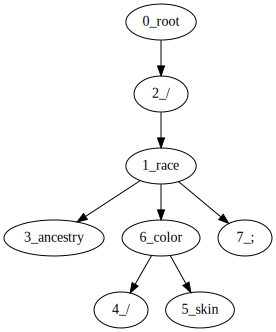

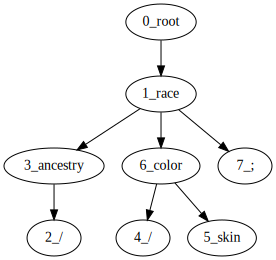

In [7]:
import graphviz

def get_graphviz(tokens, dep_to_head):
  G = graphviz.Digraph()
  tokens = ['root'] + tokens
  # print(tokens)
  for i, token in enumerate(tokens):
    G.node('q' + str(i), str(i) + '_' + token)

  for dep_i, head_i in enumerate(dep_to_head):
    h, d = tokens[head_i], tokens[dep_i + 1]
    # print(h, d)
    G.edge('q' + str(head_i), 'q' + str(dep_i + 1))
  return G

G1 = get_graphviz(input_data[i]['tokens'], constr[1:])
print(input_data[i]['tokens'])
G2 = get_graphviz(input_data[i]['tokens'], list(target.detach().numpy()))
G1
G2

## Automata Constraints

In [8]:
from rayuela.base.semiring import Boolean
from rayuela.base.symbol import Sym, ε
from rayuela.fsa.fsa import FSA
from rayuela.fsa.state import State

In [9]:
def charify(inp_number: int) -> chr:
    """Converts a number (potentially represented by two characters) into a char for easy fsa reading
    """
    return chr(ord('A')+ inp_number)

In [10]:
def one_root_FSA():
    fsa = FSA(Boolean)
    space = " "
    nl = "\n"
    alphabet = [charify(x) for x in range(-1, length_sequence+1)]
    alphabet.extend(["(", ",", ")"])

    fsa.set_I(State(0))
    for c in alphabet:
        if c != charify(0):
            fsa.add_arc(State(0), Sym(c), State(0))
            fsa.add_arc(State(1), Sym(c), State(1))
            fsa.add_arc(State(2), Sym(c), State(2))
        else:
            fsa.add_arc(State(0), Sym(c), State(1))
            fsa.add_arc(State(1), Sym(c), State(2))
            fsa.add_arc(State(2), Sym(c), State(2))
    fsa.set_F(State(0))
    fsa.set_F(State(1))
    return fsa

def no_cycle_FSA(checked_ind):
    fsa = FSA(Boolean)
    space = " "
    nl = "\n"
    alphabet = [charify(x) for x in range(-1, length_sequence+1)]
    alphabet.extend(["(", ",", ")"])

    fsa.set_I(State(0))
    for c in alphabet:
        if c == "(":
            fsa.add_arc(State(0), Sym(c), State(1))
            fsa.add_arc(State(1), Sym(c), State(0))
            fsa.add_arc(State(2), Sym(c), State(2))
            fsa.add_arc(State(3), Sym(c), State(2))
        elif c == checked_ind:
            fsa.add_arc(State(0), Sym(c), State(0))
            fsa.add_arc(State(1), Sym(c), State(2))
            fsa.add_arc(State(2), Sym(c), State(2))
            fsa.add_arc(State(3), Sym(c), State(4))
        elif c == ",":
            fsa.add_arc(State(0), Sym(c), State(0))
            fsa.add_arc(State(1), Sym(c), State(0))
            fsa.add_arc(State(2), Sym(c), State(3))
            fsa.add_arc(State(3), Sym(c), State(2))
        else:
            fsa.add_arc(State(0), Sym(c), State(0))
            fsa.add_arc(State(1), Sym(c), State(0))
            fsa.add_arc(State(2), Sym(c), State(2))
            fsa.add_arc(State(3), Sym(c), State(2))
    fsa.set_F(State(0))
    fsa.set_F(State(1))
    fsa.set_F(State(2))
    fsa.set_F(State(3))
    return fsa

In [11]:
one_root_FSA()

WFSA(3 states, <class 'rayuela.base.semiring.Boolean'>)

In [12]:
no_cycle_FSA(charify(10))

WFSA(5 states, <class 'rayuela.base.semiring.Boolean'>)

In [13]:
def intersect_all_constraints():
    result_fsa = one_root_FSA()
    for i in range(length_sequence+1):
        print(i)
        result_fsa = result_fsa.intersect(no_cycle_FSA(charify(i))).trim()
    return result_fsa

In [14]:
const_fsa = intersect_all_constraints()

0
1
2
3
4
5
6
7
8
9
10


### Check if it works as expected

In [15]:
max_seq_length=10

The following function is a helper function for our beam search with fsa to turn the parsing result into a string that can be recognized by our constraint fsa, with this let's check if our constraint fsa works as expected. 

In [16]:
def topologically_sort_and_stringify_heads(current_heads: np.ndarray) -> str:
    """Turns the heads array into a string to feed into the fsa, the following way:
    [3, 1, 2, 0, -1, 2] means (3->1) (1->2)... so these will be represented as (3,1) (1,2)...
    sorting will be done starting with the minimum left values and continuing by topological order
    until either all nodes are covered or there are no more connected nodes left, in which case we will go to
    the next minimum left value that is not covered in the heads array. An example result:
    [3, 1, 2, 0, -1, 2] -> '(-1,5)(0,4)(1,2)(2,3)(2,6)(3,1)' 
    """
    checker = current_heads.copy()
    result_string = ""
    q = deque()
    print(current_heads)

    while not np.all(checker > max_seq_length):
        curr_ind = q.popleft() if q else np.argmin(checker)
        print("Current index: ", curr_ind)
        result_string += f'({charify(checker[curr_ind])},{charify(curr_ind+1)})'
        print("Current string: ", result_string)

        
        next_indices = np.where(checker == curr_ind+1)[0]
        next_indices = next_indices[next_indices != curr_ind]
        print(next_indices)
        if next_indices.size > 0:
            q.extend(next_indices)
        
        checker[curr_ind] = max_seq_length*5

    return result_string

In [17]:
inp1 = np.array([-1, -1,  0, -1, -1, -1,  0, -1]) # breaks root constraint (>1 root)

In [18]:
input_str = topologically_sort_and_stringify_heads(inp1)
input_str
const_fsa.accept(input_str)

[-1 -1  0 -1 -1 -1  0 -1]
Current index:  0
Current string:  (@,B)
[]
Current index:  1
Current string:  (@,B)(@,C)
[]
Current index:  3
Current string:  (@,B)(@,C)(@,E)
[]
Current index:  4
Current string:  (@,B)(@,C)(@,E)(@,F)
[]
Current index:  5
Current string:  (@,B)(@,C)(@,E)(@,F)(@,G)
[]
Current index:  7
Current string:  (@,B)(@,C)(@,E)(@,F)(@,G)(@,I)
[]
Current index:  2
Current string:  (@,B)(@,C)(@,E)(@,F)(@,G)(@,I)(A,D)
[]
Current index:  6
Current string:  (@,B)(@,C)(@,E)(@,F)(@,G)(@,I)(A,D)(A,H)
[]


'(@,B)(@,C)(@,E)(@,F)(@,G)(@,I)(A,D)(A,H)'

False

In [19]:
inp2 = np.array([3, 1, 2, 0, -1, 2]) # breaks loop constraint

In [20]:
input_str = topologically_sort_and_stringify_heads(inp2)
input_str
const_fsa.accept(input_str)

[ 3  1  2  0 -1  2]
Current index:  4
Current string:  (@,F)
[]
Current index:  3
Current string:  (@,F)(A,E)
[]
Current index:  1
Current string:  (@,F)(A,E)(B,C)
[2 5]
Current index:  2
Current string:  (@,F)(A,E)(B,C)(C,D)
[0]
Current index:  5
Current string:  (@,F)(A,E)(B,C)(C,D)(C,G)
[]
Current index:  0
Current string:  (@,F)(A,E)(B,C)(C,D)(C,G)(D,B)
[]


'(@,F)(A,E)(B,C)(C,D)(C,G)(D,B)'

False

In [21]:
inp3 = np.array([6, 1, 1, 1, 1, 1]) # breaks root constraint and loop constraint

In [22]:
input_str = topologically_sort_and_stringify_heads(inp3)
input_str
const_fsa.accept(input_str)

[6 1 1 1 1 1]
Current index:  1
Current string:  (B,C)
[]
Current index:  2
Current string:  (B,C)(B,D)
[]
Current index:  3
Current string:  (B,C)(B,D)(B,E)
[]
Current index:  4
Current string:  (B,C)(B,D)(B,E)(B,F)
[]
Current index:  5
Current string:  (B,C)(B,D)(B,E)(B,F)(B,G)
[0]
Current index:  0
Current string:  (B,C)(B,D)(B,E)(B,F)(B,G)(G,B)
[]


'(B,C)(B,D)(B,E)(B,F)(B,G)(G,B)'

False

In [23]:
inp4 = np.array([4, 1, 2, -1, -1, 2]) # acceptable

In [24]:
input_str = topologically_sort_and_stringify_heads(inp4)
input_str
const_fsa.accept(input_str)

[ 4  1  2 -1 -1  2]
Current index:  3
Current string:  (@,E)
[0]
Current index:  0
Current string:  (@,E)(E,B)
[1]
Current index:  1
Current string:  (@,E)(E,B)(B,C)
[2 5]
Current index:  2
Current string:  (@,E)(E,B)(B,C)(C,D)
[]
Current index:  5
Current string:  (@,E)(E,B)(B,C)(C,D)(C,G)
[]
Current index:  4
Current string:  (@,E)(E,B)(B,C)(C,D)(C,G)(@,F)
[]


'(@,E)(E,B)(B,C)(C,D)(C,G)(@,F)'

True

In [25]:
inp5 = np.array([-1, 1, 2, 0]) # acceptable

In [26]:
input_str = topologically_sort_and_stringify_heads(inp5)
input_str
const_fsa.accept(input_str)

[-1  1  2  0]
Current index:  0
Current string:  (@,B)
[1]
Current index:  1
Current string:  (@,B)(B,C)
[2]
Current index:  2
Current string:  (@,B)(B,C)(C,D)
[]
Current index:  3
Current string:  (@,B)(B,C)(C,D)(A,E)
[]


'(@,B)(B,C)(C,D)(A,E)'

True

## Parsing without constraint checking

In [27]:
import tqdm
mst_matches = []
mst_percent_matches = []
for j in tqdm.tqdm(range(len(val_short_data))):
  input_data = val_short_data[j:j+2]
  sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
  i = 0
  word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

  loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)

  target_np = target.detach().cpu().numpy()
  mst_match = np.all(target_np == constr[1:])

  mst_percent_match = np.sum(target_np == constr[1:])/len(target_np == constr[1:])
  mst_matches.append(mst_match)
  mst_percent_matches.append(mst_percent_match)

  # big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

  # mat = big_mat[1:, 1:]  # nxn word head x dep scores
  # r = big_mat[0, 1:]  # n root -> word scores

  # extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
  # extended_mat_np = extended_mat.detach().cpu().numpy()

  # bs_out = beam_search_matrix(extended_mat_np, n_beam=10)

  # parses = [triple[1] for triple in bs_out]

  # correct = [np.all(parse == target_np) for parse in parses]
  # correct_i = np.where(correct)[0]
  # correct_i = correct_i[0] if len(correct_i) != 0 else None

  # mst_correct = [np.all(parse == constr[1:]) for parse in parses]
  # mst_correct_i = np.where(mst_correct)[0]
  # mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None

  # stats.append((mst_matches, correct_i, mst_correct_i))



100%|███████████████████████████████████████████████████████████████████████████████▋| 255/256 [00:23<00:00, 10.82it/s]


IndexError: too many indices for tensor of dimension 2

In [28]:
np.mean(mst_matches),
np.mean(mst_percent_matches)

(0.6666666666666666,)

0.8867615935262995

## Parsing with automata constraint

### One example for testing

In [29]:
input_data = val_short_data[:4]
sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
i = 0
word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

mat = big_mat[1:, 1:]  # nxn word head x dep scores
r = big_mat[0, 1:]  # n root -> word scores

extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
extended_mat_np = extended_mat.detach().cpu().numpy()

bs_out = beam_search_matrix_fsa(extended_mat_np, const_fsa, length_sequence, n_beam=1)

In [30]:
input_data[i]['tokens']
input_data[i]['head']
bs_out

['Results',
 'from',
 'a',
 'nationally',
 'representative',
 'sample',
 'of',
 'adults']

['0', '6', '6', '5', '6', '1', '8', '6']

[(array([6, 6, 6, 5, 6, 0, 8, 6], dtype=int16), -149.30055809020996)]

### Model with 3 beams

In [45]:
import tqdm
bs_mst_matches = []
bs_mst_percent_matches = []
num_beams = 1
print(f'num_beams: {num_beams}')
bs_mst_matches.append([])
bs_mst_percent_matches.append([])
for j in tqdm.tqdm(range(len(val_short_data) -1)):
    input_data = val_short_data[j:j+2]
    sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
    i = 0
    word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

    loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)


    big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

    mat = big_mat[1:, 1:]  # nxn word head x dep scores
    r = big_mat[0, 1:]  # n root -> word scores

    extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
    extended_mat_np = extended_mat.detach().cpu().numpy()

    bs_out = beam_search_matrix_fsa(extended_mat_np, const_fsa, length_sequence, n_beam=num_beams)

    bs_parse = bs_out[0][0]
    bs_mst_match = np.all(bs_parse == constr[1:])
    bs_mst_percent_match = np.sum(bs_parse == constr[1:])/len(bs_parse == constr[1:])

    bs_mst_matches[-1].append(bs_mst_match)
    bs_mst_percent_matches[-1].append(bs_mst_percent_match)

num_beams: 1


  0%|▎                                                                               | 1/255 [00:47<3:22:22, 47.81s/it]

[(array([6, 6, 6, 5, 6, 0, 8, 6], dtype=int16), -149.30055809020996)]


  1%|▋                                                                               | 2/255 [00:48<1:25:45, 20.34s/it]

[(array([0, 1], dtype=int16), -18.356449127197266)]


  1%|▉                                                                                 | 3/255 [00:54<57:59, 13.81s/it]

[(array([0, 3, 1, 1], dtype=int16), -77.98986911773682)]


  2%|█▎                                                                              | 4/255 [01:25<1:25:42, 20.49s/it]

[(array([0, 3, 1, 6, 6, 1, 1], dtype=int16), -2.80145263671875)]


  2%|█▌                                                                                | 5/255 [01:26<56:16, 13.50s/it]

[(array([0, 1], dtype=int16), -66.24103927612305)]


  2%|█▉                                                                                | 6/255 [01:27<38:32,  9.29s/it]

[(array([0, 1], dtype=int16), -42.23233890533447)]


  3%|██▎                                                                               | 7/255 [01:29<27:22,  6.62s/it]

[(array([0, 1], dtype=int16), -63.29503631591797)]


  3%|██▌                                                                               | 8/255 [01:35<26:37,  6.47s/it]

[(array([0, 3, 1, 1], dtype=int16), -36.14278221130371)]


  4%|██▉                                                                               | 9/255 [01:38<21:58,  5.36s/it]

[(array([0, 1, 2], dtype=int16), -57.266563415527344)]


  4%|███▏                                                                             | 10/255 [01:44<23:44,  5.82s/it]

[(array([0, 3, 1, 3], dtype=int16), -42.47189140319824)]


  4%|███▍                                                                             | 11/255 [01:47<20:02,  4.93s/it]

[(array([2, 0, 2], dtype=int16), -36.55851173400879)]


  5%|███▊                                                                             | 12/255 [01:50<17:30,  4.32s/it]

[(array([0, 3, 1], dtype=int16), -71.5994930267334)]


  5%|████▏                                                                            | 13/255 [01:53<15:47,  3.92s/it]

[(array([2, 0, 2], dtype=int16), -32.5551643371582)]


  5%|████▍                                                                            | 14/255 [01:56<14:28,  3.61s/it]

[(array([2, 0, 2], dtype=int16), -85.10127639770508)]


  6%|████▊                                                                            | 15/255 [01:59<13:31,  3.38s/it]

[(array([2, 0, 2], dtype=int16), -25.6915225982666)]


  6%|████▉                                                                          | 16/255 [02:44<1:03:49, 16.02s/it]

[(array([3, 3, 4, 0, 7, 7, 4, 4], dtype=int16), -54.28832149505615)]


  7%|█████▎                                                                         | 17/255 [03:53<2:06:27, 31.88s/it]

[(array([6, 6, 6, 6, 6, 0, 6, 9, 6], dtype=int16), -183.95253372192383)]


  7%|█████▌                                                                         | 18/255 [03:56<1:31:25, 23.14s/it]

[(array([0, 1, 1], dtype=int16), -23.913196563720703)]


  7%|█████▉                                                                         | 19/255 [05:04<2:23:29, 36.48s/it]

[(array([0, 3, 1, 5, 1, 8, 8, 5, 5], dtype=int16), -90.83283424377441)]


  8%|██████▏                                                                        | 20/255 [05:07<1:43:54, 26.53s/it]

[(array([0, 1, 1], dtype=int16), -29.7462739944458)]


  8%|██████▌                                                                        | 21/255 [05:29<1:38:23, 25.23s/it]

[(array([0, 6, 6, 6, 6, 1], dtype=int16), -45.10251331329346)]


  9%|██████▊                                                                        | 22/255 [06:35<2:25:30, 37.47s/it]

[(array([2, 4, 4, 0, 8, 8, 8, 4, 4], dtype=int16), -73.26775455474854)]


  9%|███████▏                                                                       | 23/255 [06:36<1:42:45, 26.57s/it]

[(array([0, 1], dtype=int16), -13.111198425292969)]


  9%|███████▍                                                                       | 24/255 [06:37<1:12:53, 18.93s/it]

[(array([0, 1], dtype=int16), -13.111211776733398)]


 10%|███████▋                                                                       | 25/255 [07:23<1:43:21, 26.96s/it]

[(array([3, 3, 5, 5, 0, 7, 5, 5], dtype=int16), 8.518848419189453)]


 10%|████████                                                                       | 26/255 [07:24<1:13:17, 19.20s/it]

[(array([0, 1], dtype=int16), -24.485973358154297)]


 11%|████████▌                                                                        | 27/255 [07:25<52:20, 13.78s/it]

[(array([2, 0], dtype=int16), -50.53729438781738)]


 11%|████████▋                                                                      | 28/255 [08:36<1:56:20, 30.75s/it]

[(array([4, 1, 4, 0, 6, 1, 8, 6, 4], dtype=int16), 156.99615573883057)]


 11%|████████▉                                                                      | 29/255 [09:21<2:12:35, 35.20s/it]

[(array([3, 3, 0, 5, 3, 7, 3, 3], dtype=int16), 73.39049625396729)]


 12%|█████████▎                                                                     | 30/255 [09:27<1:39:08, 26.44s/it]

[(array([4, 0, 4, 2], dtype=int16), -35.41568374633789)]


 12%|█████████▌                                                                     | 31/255 [09:58<1:43:30, 27.73s/it]

[(array([2, 0, 5, 5, 2, 2, 2], dtype=int16), 156.93054389953613)]


 13%|█████████▉                                                                     | 32/255 [11:04<2:25:18, 39.10s/it]

[(array([4, 4, 4, 0, 6, 4, 8, 4, 4], dtype=int16), -15.637337684631348)]


 13%|██████████▏                                                                    | 33/255 [11:04<1:41:37, 27.47s/it]

[(array([0], dtype=int16), -10.055390357971191)]


 13%|██████████▌                                                                    | 34/255 [11:49<2:01:14, 32.92s/it]

[(array([3, 6, 0, 6, 7, 3, 6, 3], dtype=int16), -135.12293338775635)]


 14%|██████████▊                                                                    | 35/255 [12:20<1:57:43, 32.11s/it]

[(array([2, 3, 6, 6, 6, 0, 6], dtype=int16), -154.07481479644775)]


 14%|███████████▏                                                                   | 36/255 [12:50<1:55:17, 31.59s/it]

[(array([3, 3, 0, 3, 3, 3, 3], dtype=int16), -217.25213718414307)]


 15%|███████████▍                                                                   | 37/255 [13:21<1:54:25, 31.49s/it]

[(array([3, 3, 0, 5, 3, 5, 3], dtype=int16), -69.80475997924805)]


 15%|███████████▊                                                                   | 38/255 [13:40<1:40:24, 27.76s/it]

[(array([5, 5, 5, 5, 0, 5], dtype=int16), -123.30189228057861)]


 15%|████████████                                                                   | 39/255 [13:52<1:22:08, 22.82s/it]

[(array([2, 0, 4, 2, 2], dtype=int16), -18.936744689941406)]


 16%|████████████▍                                                                  | 40/255 [14:57<2:07:46, 35.66s/it]

[(array([5, 3, 4, 5, 0, 8, 8, 5, 5], dtype=int16), -27.735017776489258)]


 16%|████████████▋                                                                  | 41/255 [15:28<2:01:28, 34.06s/it]

[(array([3, 3, 0, 3, 6, 3, 3], dtype=int16), -142.9273500442505)]


 16%|█████████████                                                                  | 42/255 [15:30<1:27:38, 24.69s/it]

[(array([2, 0, 2], dtype=int16), -15.397510528564453)]


 17%|█████████████▎                                                                 | 43/255 [16:16<1:49:40, 31.04s/it]

[(array([2, 3, 6, 2, 2, 0, 6, 6], dtype=int16), -135.41814613342285)]


 17%|█████████████▋                                                                 | 44/255 [16:46<1:48:08, 30.75s/it]

[(array([2, 0, 6, 6, 6, 2, 2], dtype=int16), -99.12908840179443)]


 18%|█████████████▉                                                                 | 45/255 [17:17<1:47:15, 30.64s/it]

[(array([2, 0, 2, 6, 2, 2, 2], dtype=int16), 27.541287422180176)]


 18%|██████████████▎                                                                | 46/255 [18:22<2:22:58, 41.04s/it]

[(array([3, 3, 0, 3, 8, 8, 8, 3, 3], dtype=int16), -96.69469356536865)]


 18%|██████████████▌                                                                | 47/255 [18:25<1:42:21, 29.53s/it]

[(array([0, 1, 1], dtype=int16), -43.71372032165527)]


 19%|██████████████▊                                                                | 48/255 [19:09<1:57:01, 33.92s/it]

[(array([6, 3, 6, 6, 6, 0, 6, 6], dtype=int16), -147.78965663909912)]


 19%|███████████████▏                                                               | 49/255 [19:51<2:05:06, 36.44s/it]

[(array([6, 4, 4, 0, 6, 4, 4, 4], dtype=int16), -109.43223476409912)]


 20%|███████████████▍                                                               | 50/255 [20:19<1:55:55, 33.93s/it]

[(array([6, 4, 4, 6, 6, 0, 6], dtype=int16), -130.84261798858643)]


 20%|███████████████▊                                                               | 51/255 [21:01<2:03:09, 36.22s/it]

[(array([2, 0, 5, 5, 2, 7, 5, 2], dtype=int16), 19.466578483581543)]


 20%|████████████████                                                               | 52/255 [21:43<2:08:24, 37.95s/it]

[(array([4, 4, 4, 0, 7, 7, 4, 4], dtype=int16), -70.4324083328247)]


 21%|████████████████▍                                                              | 53/255 [22:01<1:47:20, 31.88s/it]

[(array([3, 3, 0, 3, 3, 3], dtype=int16), -172.67176246643066)]


 21%|████████████████▋                                                              | 54/255 [22:06<1:20:19, 23.98s/it]

[(array([0, 1, 1, 1], dtype=int16), -42.67728233337402)]


 22%|█████████████████                                                              | 55/255 [22:16<1:06:16, 19.88s/it]

[(array([2, 3, 0, 3, 3], dtype=int16), -48.13954448699951)]


 22%|█████████████████▎                                                             | 56/255 [23:17<1:46:52, 32.22s/it]

[(array([2, 0, 5, 5, 2, 8, 8, 5, 2], dtype=int16), -101.1060905456543)]


 22%|█████████████████▋                                                             | 57/255 [23:47<1:43:16, 31.29s/it]

[(array([4, 4, 4, 6, 6, 0, 6], dtype=int16), -63.70725059509277)]


 23%|█████████████████▉                                                             | 58/255 [23:58<1:23:13, 25.35s/it]

[(array([2, 0, 4, 2, 2], dtype=int16), -66.11412620544434)]


 23%|██████████████████▋                                                              | 59/255 [23:59<58:58, 18.06s/it]

[(array([0, 1], dtype=int16), -8.511991500854492)]


 24%|██████████████████▌                                                            | 60/255 [24:28<1:09:10, 21.29s/it]

[(array([6, 3, 6, 0, 6, 4, 6], dtype=int16), -234.2134494781494)]


 24%|██████████████████▉                                                            | 61/255 [24:47<1:06:17, 20.50s/it]

[(array([2, 0, 2, 5, 2, 2], dtype=int16), -40.13825988769531)]


 24%|███████████████████▏                                                           | 62/255 [25:47<1:44:51, 32.60s/it]

[(array([2, 3, 0, 5, 3, 7, 5, 3, 3], dtype=int16), -138.25659370422363)]


 25%|███████████████████▌                                                           | 63/255 [26:48<2:11:37, 41.13s/it]

[(array([8, 8, 4, 0, 8, 8, 8, 4, 8], dtype=int16), -146.05942726135254)]


 25%|███████████████████▊                                                           | 64/255 [27:31<2:12:41, 41.68s/it]

[(array([2, 0, 5, 5, 2, 7, 5, 7], dtype=int16), -212.36495876312256)]


 25%|████████████████████▏                                                          | 65/255 [27:42<1:42:23, 32.33s/it]

[(array([2, 0, 4, 2, 2], dtype=int16), 25.46737766265869)]


 26%|████████████████████▍                                                          | 66/255 [28:43<2:09:06, 40.99s/it]

[(array([3, 3, 8, 3, 3, 3, 8, 0, 8], dtype=int16), 275.94163703918457)]


 26%|████████████████████▊                                                          | 67/255 [29:12<1:56:45, 37.26s/it]

[(array([3, 3, 0, 6, 6, 3, 3], dtype=int16), -3.957545280456543)]


 27%|█████████████████████                                                          | 68/255 [29:29<1:37:46, 31.37s/it]

[(array([2, 0, 4, 2, 2, 2], dtype=int16), 30.67875576019287)]


 27%|█████████████████████▍                                                         | 69/255 [29:32<1:10:31, 22.75s/it]

[(array([2, 0, 2], dtype=int16), -28.572702407836914)]


 27%|██████████████████████▏                                                          | 70/255 [29:33<50:03, 16.24s/it]

[(array([2, 0], dtype=int16), -46.417232513427734)]


 28%|█████████████████████▉                                                         | 71/255 [30:01<1:00:47, 19.82s/it]

[(array([2, 0, 6, 2, 6, 2, 2], dtype=int16), -147.23870944976807)]


 28%|██████████████████████▎                                                        | 72/255 [30:29<1:08:02, 22.31s/it]

[(array([5, 5, 5, 3, 0, 5, 5], dtype=int16), -52.294859886169434)]


 29%|██████████████████████▌                                                        | 73/255 [30:57<1:12:41, 23.96s/it]

[(array([3, 1, 0, 5, 3, 3, 3], dtype=int16), -204.52375507354736)]


 29%|██████████████████████▉                                                        | 74/255 [31:25<1:16:01, 25.20s/it]

[(array([2, 5, 2, 5, 0, 5, 5], dtype=int16), 9.810072898864746)]


 29%|███████████████████████▏                                                       | 75/255 [31:53<1:18:05, 26.03s/it]

[(array([2, 5, 2, 5, 0, 5, 5], dtype=int16), 9.810072898864746)]


 30%|███████████████████████▌                                                       | 76/255 [32:04<1:03:40, 21.35s/it]

[(array([4, 4, 4, 0, 4], dtype=int16), -158.19549942016602)]


 30%|████████████████████████▍                                                        | 77/255 [32:04<44:37, 15.04s/it]

[(array([0], dtype=int16), -6.770124435424805)]


 31%|████████████████████████▊                                                        | 78/255 [32:04<31:20, 10.62s/it]

[(array([0], dtype=int16), -6.770124435424805)]


 31%|█████████████████████████                                                        | 79/255 [32:15<31:03, 10.59s/it]

[(array([2, 0, 4, 2, 2], dtype=int16), -148.94342613220215)]


 31%|████████████████████████▊                                                      | 80/255 [33:17<1:15:49, 26.00s/it]

[(array([3, 3, 6, 6, 6, 0, 8, 6, 6], dtype=int16), 199.24769592285156)]


 32%|█████████████████████████                                                      | 81/255 [34:17<1:45:30, 36.38s/it]

[(array([3, 3, 0, 5, 3, 8, 8, 3, 3], dtype=int16), -64.82843112945557)]


 32%|█████████████████████████▍                                                     | 82/255 [34:36<1:29:47, 31.14s/it]

[(array([2, 3, 0, 5, 3, 3], dtype=int16), -47.095863342285156)]


 33%|█████████████████████████▋                                                     | 83/255 [34:42<1:07:23, 23.51s/it]

[(array([0, 3, 1, 1], dtype=int16), -94.50948715209961)]


 33%|██████████████████████████                                                     | 84/255 [35:50<1:44:45, 36.76s/it]

[(array([3, 3, 0, 5, 3, 5, 8, 5, 3], dtype=int16), -56.462331771850586)]


 33%|██████████████████████████▎                                                    | 85/255 [36:51<2:05:08, 44.17s/it]

[(array([2, 0, 5, 5, 6, 2, 8, 6, 2], dtype=int16), 115.33935070037842)]


 34%|██████████████████████████▋                                                    | 86/255 [37:33<2:02:31, 43.50s/it]

[(array([4, 7, 4, 7, 7, 7, 0, 7], dtype=int16), -53.07006072998047)]


 34%|██████████████████████████▉                                                    | 87/255 [38:03<1:50:02, 39.30s/it]

[(array([2, 6, 2, 6, 6, 0, 6], dtype=int16), -48.97237014770508)]


 35%|███████████████████████████▎                                                   | 88/255 [39:03<2:06:39, 45.51s/it]

[(array([7, 1, 7, 7, 7, 7, 0, 7, 7], dtype=int16), -186.15621185302734)]


 35%|███████████████████████████▌                                                   | 89/255 [39:44<2:02:40, 44.34s/it]

[(array([0, 6, 6, 6, 6, 1, 8, 6], dtype=int16), -103.93814086914062)]


 35%|███████████████████████████▉                                                   | 90/255 [39:50<1:29:54, 32.70s/it]

[(array([0, 3, 1, 1], dtype=int16), -51.69460964202881)]


 36%|████████████████████████████▏                                                  | 91/255 [40:31<1:36:44, 35.39s/it]

[(array([0, 7, 5, 5, 7, 7, 1, 5], dtype=int16), -147.81563472747803)]


 36%|████████████████████████████▌                                                  | 92/255 [40:37<1:11:48, 26.43s/it]

[(array([3, 3, 0, 3], dtype=int16), -14.053327560424805)]


 36%|████████████████████████████▊                                                  | 93/255 [41:19<1:23:49, 31.05s/it]

[(array([4, 4, 4, 7, 7, 7, 0, 7], dtype=int16), -293.84423637390137)]


 37%|█████████████████████████████                                                  | 94/255 [41:36<1:12:21, 26.97s/it]

[(array([0, 4, 4, 1, 6, 4], dtype=int16), 348.13332748413086)]


 37%|██████████████████████████████▏                                                  | 95/255 [41:36<50:37, 18.98s/it]

[(array([0], dtype=int16), -6.7701263427734375)]


 38%|█████████████████████████████▋                                                 | 96/255 [42:38<1:23:52, 31.65s/it]

[(array([5, 5, 5, 5, 0, 5, 8, 5, 5], dtype=int16), -154.47074508666992)]


 38%|██████████████████████████████                                                 | 97/255 [43:19<1:31:20, 34.69s/it]

[(array([4, 4, 4, 0, 6, 4, 1, 4], dtype=int16), -161.15764713287354)]


 38%|██████████████████████████████▎                                                | 98/255 [43:22<1:05:35, 25.07s/it]

[(array([0, 1, 1], dtype=int16), -29.89072895050049)]


 39%|██████████████████████████████▋                                                | 99/255 [43:50<1:07:19, 25.90s/it]

[(array([6, 5, 5, 5, 0, 5, 5], dtype=int16), -373.6126136779785)]


 39%|███████████████████████████████▎                                                | 100/255 [43:53<49:01, 18.98s/it]

[(array([0, 1, 1], dtype=int16), -14.639002799987793)]


 40%|███████████████████████████████▋                                                | 101/255 [44:10<47:36, 18.55s/it]

[(array([0, 3, 1, 5, 1, 1], dtype=int16), -84.96236419677734)]


 40%|████████████████████████████████                                                | 102/255 [44:28<46:28, 18.23s/it]

[(array([0, 3, 1, 5, 3, 1], dtype=int16), -196.16018676757812)]


 40%|████████████████████████████████▎                                               | 103/255 [44:33<36:30, 14.41s/it]

[(array([0, 3, 1, 1], dtype=int16), -83.83464241027832)]


 41%|████████████████████████████████▋                                               | 104/255 [44:51<38:33, 15.32s/it]

[(array([0, 5, 4, 1, 1, 5], dtype=int16), -30.41847324371338)]


 41%|████████████████████████████████▉                                               | 105/255 [45:09<40:18, 16.12s/it]

[(array([0, 4, 4, 1, 6, 4], dtype=int16), 362.89729499816895)]


 42%|█████████████████████████████████▎                                              | 106/255 [45:26<41:04, 16.54s/it]

[(array([3, 3, 0, 3, 3, 3], dtype=int16), -50.75829601287842)]


 42%|████████████████████████████████▋                                             | 107/255 [46:12<1:02:30, 25.34s/it]

[(array([6, 5, 5, 5, 6, 0, 6, 5], dtype=int16), -189.2701301574707)]


 42%|█████████████████████████████████▉                                              | 108/255 [46:22<51:04, 20.84s/it]

[(array([3, 4, 4, 0, 4], dtype=int16), -167.6317901611328)]


 43%|██████████████████████████████████▏                                             | 109/255 [46:29<40:16, 16.55s/it]

[(array([0, 1, 1, 1], dtype=int16), -114.2257490158081)]


 43%|██████████████████████████████████▌                                             | 110/255 [46:32<30:00, 12.42s/it]

[(array([0, 3, 1], dtype=int16), -48.1386079788208)]


 44%|██████████████████████████████████▊                                             | 111/255 [46:38<25:26, 10.60s/it]

[(array([0, 3, 1, 3], dtype=int16), -141.7404556274414)]


 44%|███████████████████████████████████▏                                            | 112/255 [46:49<25:41, 10.78s/it]

[(array([3, 3, 0, 5, 3], dtype=int16), -62.515005111694336)]


 44%|███████████████████████████████████▍                                            | 113/255 [46:56<22:46,  9.62s/it]

[(array([3, 3, 0, 3], dtype=int16), -216.19050788879395)]


 45%|███████████████████████████████████▊                                            | 114/255 [46:57<16:40,  7.09s/it]

[(array([2, 0], dtype=int16), -39.402488708496094)]


 45%|████████████████████████████████████                                            | 115/255 [47:09<19:30,  8.36s/it]

[(array([3, 1, 0, 3, 1], dtype=int16), -98.62771606445312)]


 45%|████████████████████████████████████▍                                           | 116/255 [47:54<44:56, 19.40s/it]

[(array([0, 1, 1, 7, 3, 1, 3, 1], dtype=int16), -190.77953624725342)]


 46%|████████████████████████████████████▋                                           | 117/255 [48:12<43:30, 18.91s/it]

[(array([3, 3, 0, 5, 3, 3], dtype=int16), -147.9871425628662)]


 46%|█████████████████████████████████████                                           | 118/255 [48:17<34:02, 14.91s/it]

[(array([2, 0, 1, 1], dtype=int16), -148.7898998260498)]


 47%|█████████████████████████████████████▎                                          | 119/255 [48:18<24:20, 10.74s/it]

[(array([0, 1], dtype=int16), -89.62084197998047)]


 47%|█████████████████████████████████████▋                                          | 120/255 [48:36<28:46, 12.79s/it]

[(array([2, 0, 2, 5, 2, 2], dtype=int16), -4.840778350830078)]


 47%|█████████████████████████████████████▉                                          | 121/255 [48:53<31:44, 14.22s/it]

[(array([0, 4, 4, 1, 6, 4], dtype=int16), 369.19936084747314)]


 48%|██████████████████████████████████████▎                                         | 122/255 [49:04<28:54, 13.04s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.503426551818848)]


 48%|██████████████████████████████████████▌                                         | 123/255 [49:06<21:48,  9.91s/it]

[(array([0, 1, 1], dtype=int16), -50.302846908569336)]


 49%|██████████████████████████████████████▉                                         | 124/255 [49:17<21:54, 10.03s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.50336265563965)]


 49%|███████████████████████████████████████▏                                        | 125/255 [49:27<21:54, 10.11s/it]

[(array([0, 3, 1, 5, 1], dtype=int16), -32.860517501831055)]


 49%|███████████████████████████████████████▌                                        | 126/255 [49:37<21:57, 10.21s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.50336265563965)]


 50%|███████████████████████████████████████▊                                        | 127/255 [50:19<41:56, 19.66s/it]

[(array([2, 0, 7, 7, 6, 7, 2, 2], dtype=int16), -59.21164798736572)]


 50%|████████████████████████████████████████▏                                       | 128/255 [50:29<35:38, 16.84s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.50336265563965)]


 51%|████████████████████████████████████████▍                                       | 129/255 [50:47<36:00, 17.15s/it]

[(array([2, 3, 0, 5, 3, 3], dtype=int16), -13.224489212036133)]


 51%|████████████████████████████████████████▊                                       | 130/255 [50:58<31:35, 15.16s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.50336265563965)]


 51%|█████████████████████████████████████████                                       | 131/255 [51:15<32:50, 15.89s/it]

[(array([2, 0, 4, 2, 6, 4], dtype=int16), -17.52479839324951)]


 52%|█████████████████████████████████████████▍                                      | 132/255 [51:33<33:29, 16.34s/it]

[(array([0, 1, 2, 5, 1, 1], dtype=int16), -81.79160976409912)]


 52%|█████████████████████████████████████████▋                                      | 133/255 [51:43<29:31, 14.52s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.503426551818848)]


 53%|██████████████████████████████████████████                                      | 134/255 [51:43<20:42, 10.27s/it]

[(array([0], dtype=int16), -50.81216812133789)]


 53%|██████████████████████████████████████████▎                                     | 135/255 [51:44<14:35,  7.29s/it]

[(array([0], dtype=int16), 8.901622772216797)]


 53%|██████████████████████████████████████████▋                                     | 136/255 [51:54<16:20,  8.24s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.503426551818848)]


 54%|██████████████████████████████████████████▉                                     | 137/255 [51:54<11:32,  5.87s/it]

[(array([0], dtype=int16), -14.154973030090332)]


 54%|███████████████████████████████████████████▎                                    | 138/255 [52:05<14:04,  7.22s/it]

[(array([2, 4, 4, 0, 4], dtype=int16), -99.9891529083252)]


 55%|███████████████████████████████████████████▌                                    | 139/255 [52:15<15:46,  8.16s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.503426551818848)]


 55%|███████████████████████████████████████████▉                                    | 140/255 [52:16<11:08,  5.81s/it]

[(array([0], dtype=int16), -28.623661041259766)]


 55%|████████████████████████████████████████████▏                                   | 141/255 [52:26<13:32,  7.13s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.503334999084473)]


 56%|████████████████████████████████████████████▌                                   | 142/255 [53:01<29:04, 15.44s/it]

[(array([2, 0, 4, 2, 7, 7, 2], dtype=int16), -86.52420997619629)]


 56%|████████████████████████████████████████████▊                                   | 143/255 [53:23<32:40, 17.51s/it]

[(array([0, 1, 1, 5, 1, 1], dtype=int16), -63.111860275268555)]


 56%|█████████████████████████████████████████████▏                                  | 144/255 [53:36<29:41, 16.05s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.50336265563965)]


 57%|█████████████████████████████████████████████▍                                  | 145/255 [53:50<28:41, 15.65s/it]

[(array([2, 0, 5, 5, 2], dtype=int16), -73.17780017852783)]


 57%|█████████████████████████████████████████████▊                                  | 146/255 [54:04<27:11, 14.96s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -18.503426551818848)]


 58%|██████████████████████████████████████████████                                  | 147/255 [54:27<31:33, 17.53s/it]

[(array([0, 4, 4, 1, 6, 4], dtype=int16), 226.71831703186035)]


 58%|██████████████████████████████████████████████▍                                 | 148/255 [54:51<34:42, 19.47s/it]

[(array([4, 4, 1, 0, 4, 1], dtype=int16), -47.193891525268555)]


 58%|██████████████████████████████████████████████▋                                 | 149/255 [54:58<27:58, 15.83s/it]

[(array([0, 3, 1, 1], dtype=int16), -0.9082069396972656)]


 59%|███████████████████████████████████████████████                                 | 150/255 [55:12<26:35, 15.19s/it]

[(array([0, 1, 5, 5, 1], dtype=int16), -55.03519248962402)]


 59%|███████████████████████████████████████████████▎                                | 151/255 [55:22<23:19, 13.46s/it]

[(array([0, 3, 1, 1], dtype=int16), -0.9082069396972656)]


 60%|███████████████████████████████████████████████▋                                | 152/255 [55:31<20:58, 12.22s/it]

[(array([0, 3, 1, 1], dtype=int16), -0.9082126617431641)]


 60%|████████████████████████████████████████████████                                | 153/255 [56:20<39:26, 23.20s/it]

[(array([5, 1, 5, 1, 0, 7, 5, 7], dtype=int16), -103.26944637298584)]


 60%|████████████████████████████████████████████████▎                               | 154/255 [56:48<41:25, 24.61s/it]

[(array([4, 3, 4, 0, 7, 7, 1], dtype=int16), -98.15212631225586)]


 61%|████████████████████████████████████████████████▋                               | 155/255 [57:05<37:27, 22.48s/it]

[(array([0, 4, 4, 1, 6, 4], dtype=int16), 306.3125591278076)]


 61%|████████████████████████████████████████████████▉                               | 156/255 [57:05<26:08, 15.84s/it]

[(array([0], dtype=int16), -39.61559295654297)]


 62%|█████████████████████████████████████████████████▎                              | 157/255 [57:08<19:23, 11.87s/it]

[(array([0, 1, 1], dtype=int16), 3.746964454650879)]


 62%|█████████████████████████████████████████████████▌                              | 158/255 [57:09<13:56,  8.62s/it]

[(array([0, 1], dtype=int16), -48.43818473815918)]


 62%|█████████████████████████████████████████████████▉                              | 159/255 [57:15<12:22,  7.73s/it]

[(array([2, 0, 4, 2], dtype=int16), 151.94210243225098)]


 63%|██████████████████████████████████████████████████▏                             | 160/255 [57:15<08:43,  5.51s/it]

[(array([0], dtype=int16), -43.50286102294922)]


 63%|██████████████████████████████████████████████████▌                             | 161/255 [57:15<06:11,  3.95s/it]

[(array([0], dtype=int16), -15.696906089782715)]


 64%|██████████████████████████████████████████████████▊                             | 162/255 [57:16<04:45,  3.07s/it]

[(array([2, 0], dtype=int16), -25.96731185913086)]


 64%|███████████████████████████████████████████████████▏                            | 163/255 [57:19<04:30,  2.94s/it]

[(array([0, 3, 1], dtype=int16), -60.39206886291504)]


 64%|███████████████████████████████████████████████████▍                            | 164/255 [57:20<03:35,  2.37s/it]

[(array([0, 1], dtype=int16), -48.56698799133301)]


 65%|███████████████████████████████████████████████████▊                            | 165/255 [57:20<02:37,  1.75s/it]

[(array([0], dtype=int16), -34.802215576171875)]


 65%|████████████████████████████████████████████████████                            | 166/255 [57:21<01:57,  1.32s/it]

[(array([0], dtype=int16), -8.490164756774902)]


 65%|████████████████████████████████████████████████████▍                           | 167/255 [57:21<01:30,  1.03s/it]

[(array([0], dtype=int16), -20.43378448486328)]


 66%|████████████████████████████████████████████████████▋                           | 168/255 [57:22<01:31,  1.05s/it]

[(array([2, 0], dtype=int16), -89.8062744140625)]


 66%|█████████████████████████████████████████████████████                           | 169/255 [57:50<12:58,  9.06s/it]

[(array([0, 1, 4, 7, 7, 7, 1], dtype=int16), -60.892940521240234)]


 67%|█████████████████████████████████████████████████████▎                          | 170/255 [58:32<26:52, 18.97s/it]

[(array([2, 5, 2, 5, 0, 5, 5, 5], dtype=int16), 65.0988826751709)]


 67%|█████████████████████████████████████████████████████▋                          | 171/255 [58:32<18:43, 13.38s/it]

[(array([0], dtype=int16), -26.767532348632812)]


 67%|█████████████████████████████████████████████████████▉                          | 172/255 [59:33<38:11, 27.61s/it]

[(array([8, 1, 8, 5, 0, 7, 5, 5, 8], dtype=int16), -174.39044666290283)]


 68%|████████████████████████████████████████████████████▉                         | 173/255 [1:00:34<51:18, 37.54s/it]

[(array([4, 4, 4, 0, 6, 4, 8, 6, 4], dtype=int16), -183.09688186645508)]


 68%|█████████████████████████████████████████████████████▏                        | 174/255 [1:01:34<59:42, 44.23s/it]

[(array([0, 1, 4, 1, 4, 7, 4, 4, 1], dtype=int16), -117.10605525970459)]


 69%|█████████████████████████████████████████████████████▌                        | 175/255 [1:02:17<58:28, 43.85s/it]

[(array([2, 7, 2, 5, 7, 7, 0, 7], dtype=int16), -0.9273271560668945)]


 69%|█████████████████████████████████████████████████████▊                        | 176/255 [1:02:17<40:33, 30.81s/it]

[(array([0], dtype=int16), -28.984397888183594)]


 69%|██████████████████████████████████████████████████████▏                       | 177/255 [1:02:59<44:17, 34.07s/it]

[(array([3, 3, 0, 5, 3, 5, 8, 5], dtype=int16), -67.46167469024658)]


 70%|██████████████████████████████████████████████████████▍                       | 178/255 [1:02:59<30:44, 23.95s/it]

[(array([0], dtype=int16), -8.490154266357422)]


 70%|██████████████████████████████████████████████████████▊                       | 179/255 [1:03:41<37:05, 29.28s/it]

[(array([5, 5, 5, 5, 0, 7, 5, 5], dtype=int16), -130.26058959960938)]


 71%|███████████████████████████████████████████████████████                       | 180/255 [1:04:24<41:47, 33.43s/it]

[(array([2, 5, 5, 5, 0, 7, 5, 5], dtype=int16), -156.29092407226562)]


 71%|███████████████████████████████████████████████████████▎                      | 181/255 [1:04:24<28:59, 23.51s/it]

[(array([0], dtype=int16), -1.1455802917480469)]


 71%|███████████████████████████████████████████████████████▋                      | 182/255 [1:04:52<30:06, 24.75s/it]

[(array([3, 3, 0, 6, 6, 3, 3], dtype=int16), 83.15536785125732)]


 72%|███████████████████████████████████████████████████████▉                      | 183/255 [1:05:11<27:37, 23.03s/it]

[(array([4, 3, 1, 0, 6, 1], dtype=int16), -24.072592735290527)]


 72%|████████████████████████████████████████████████████████▎                     | 184/255 [1:05:11<19:13, 16.25s/it]

[(array([0], dtype=int16), -21.231538772583008)]


 73%|████████████████████████████████████████████████████████▌                     | 185/255 [1:05:55<28:26, 24.38s/it]

[(array([3, 3, 0, 6, 7, 3, 6, 6], dtype=int16), -110.72298622131348)]


 73%|████████████████████████████████████████████████████████▉                     | 186/255 [1:05:56<19:58, 17.37s/it]

[(array([0, 1], dtype=int16), -42.7028923034668)]


 73%|█████████████████████████████████████████████████████████▏                    | 187/255 [1:05:58<14:41, 12.96s/it]

[(array([2, 0, 2], dtype=int16), -25.91667938232422)]


 74%|█████████████████████████████████████████████████████████▌                    | 188/255 [1:06:09<13:35, 12.18s/it]

[(array([3, 3, 0, 5, 3], dtype=int16), -123.68164730072021)]


 74%|█████████████████████████████████████████████████████████▊                    | 189/255 [1:06:37<18:42, 17.01s/it]

[(array([0, 1, 4, 1, 7, 7, 1], dtype=int16), 47.113800048828125)]


 75%|██████████████████████████████████████████████████████████                    | 190/255 [1:06:47<16:15, 15.01s/it]

[(array([0, 4, 4, 1, 1], dtype=int16), -89.59147262573242)]


 75%|██████████████████████████████████████████████████████████▍                   | 191/255 [1:06:53<12:59, 12.17s/it]

[(array([0, 3, 1, 1], dtype=int16), -51.56775665283203)]


 75%|██████████████████████████████████████████████████████████▋                   | 192/255 [1:07:53<28:00, 26.68s/it]

[(array([0, 3, 1, 1, 8, 7, 8, 4, 1], dtype=int16), -121.65764045715332)]


 76%|███████████████████████████████████████████████████████████                   | 193/255 [1:08:22<28:04, 27.18s/it]

[(array([0, 1, 4, 1, 7, 7, 1], dtype=int16), -23.10103130340576)]


 76%|███████████████████████████████████████████████████████████▎                  | 194/255 [1:08:28<21:05, 20.74s/it]

[(array([0, 1, 1, 1], dtype=int16), -59.240370750427246)]


 76%|███████████████████████████████████████████████████████████▋                  | 195/255 [1:08:33<16:13, 16.22s/it]

[(array([0, 3, 1, 1], dtype=int16), -39.539313316345215)]


 77%|███████████████████████████████████████████████████████████▉                  | 196/255 [1:09:34<29:01, 29.52s/it]

[(array([0, 3, 1, 8, 8, 8, 8, 3, 1], dtype=int16), -66.576340675354)]


 77%|████████████████████████████████████████████████████████████▎                 | 197/255 [1:09:44<22:59, 23.78s/it]

[(array([0, 4, 4, 1, 1], dtype=int16), -33.03915023803711)]


 78%|████████████████████████████████████████████████████████████▌                 | 198/255 [1:10:15<24:38, 25.94s/it]

[(array([2, 3, 5, 5, 0, 5, 5], dtype=int16), -152.21150588989258)]


 78%|████████████████████████████████████████████████████████████▊                 | 199/255 [1:10:21<18:31, 19.85s/it]

[(array([0, 3, 1, 1], dtype=int16), -25.383747100830078)]


 78%|█████████████████████████████████████████████████████████████▏                | 200/255 [1:10:31<15:34, 17.00s/it]

[(array([0, 3, 4, 1, 4], dtype=int16), -153.85088920593262)]


 79%|█████████████████████████████████████████████████████████████▍                | 201/255 [1:10:41<13:31, 15.02s/it]

[(array([3, 3, 0, 5, 3], dtype=int16), -56.78388595581055)]


 79%|█████████████████████████████████████████████████████████████▊                | 202/255 [1:10:44<09:59, 11.31s/it]

[(array([2, 0, 2], dtype=int16), -62.498796463012695)]


 80%|██████████████████████████████████████████████████████████████                | 203/255 [1:10:50<08:18,  9.59s/it]

[(array([4, 4, 4, 0], dtype=int16), -92.46246242523193)]


 80%|██████████████████████████████████████████████████████████████▍               | 204/255 [1:10:55<07:06,  8.37s/it]

[(array([4, 4, 4, 0], dtype=int16), -80.06383800506592)]


 80%|██████████████████████████████████████████████████████████████▋               | 205/255 [1:10:56<04:57,  5.96s/it]

[(array([0], dtype=int16), -19.12884521484375)]


 81%|███████████████████████████████████████████████████████████████               | 206/255 [1:11:38<13:49, 16.93s/it]

[(array([0, 1, 7, 7, 7, 7, 1, 7], dtype=int16), -126.88262462615967)]


 81%|███████████████████████████████████████████████████████████████▎              | 207/255 [1:12:39<24:02, 30.06s/it]

[(array([2, 0, 5, 5, 9, 5, 8, 9, 1], dtype=int16), -22.16806411743164)]


 82%|███████████████████████████████████████████████████████████████▌              | 208/255 [1:13:20<26:12, 33.46s/it]

[(array([2, 8, 5, 5, 2, 5, 8, 0], dtype=int16), 45.427757263183594)]


 82%|███████████████████████████████████████████████████████████████▉              | 209/255 [1:13:26<19:14, 25.10s/it]

[(array([2, 3, 0, 3], dtype=int16), -87.22410774230957)]


 82%|████████████████████████████████████████████████████████████████▏             | 210/255 [1:13:29<13:48, 18.41s/it]

[(array([2, 0, 1], dtype=int16), -65.53939247131348)]


 83%|████████████████████████████████████████████████████████████████▌             | 211/255 [1:13:57<15:36, 21.28s/it]

[(array([2, 0, 5, 5, 2, 5, 4], dtype=int16), 15.088113784790039)]


 83%|████████████████████████████████████████████████████████████████▊             | 212/255 [1:14:39<19:45, 27.56s/it]

[(array([2, 7, 5, 5, 2, 5, 8, 0], dtype=int16), 57.81930923461914)]


 84%|█████████████████████████████████████████████████████████████████▏            | 213/255 [1:14:44<14:40, 20.98s/it]

[(array([2, 3, 4, 0], dtype=int16), -60.225725173950195)]


 84%|█████████████████████████████████████████████████████████████████▍            | 214/255 [1:14:55<12:16, 17.96s/it]

[(array([2, 0, 2, 2, 2], dtype=int16), -101.91682624816895)]


 84%|█████████████████████████████████████████████████████████████████▊            | 215/255 [1:15:37<16:47, 25.18s/it]

[(array([0, 1, 7, 7, 7, 7, 1, 7], dtype=int16), -136.15226459503174)]


 85%|██████████████████████████████████████████████████████████████████            | 216/255 [1:16:20<19:41, 30.30s/it]

[(array([4, 1, 7, 7, 6, 7, 0, 7], dtype=int16), -119.50796318054199)]


 85%|██████████████████████████████████████████████████████████████████▍           | 217/255 [1:16:25<14:32, 22.95s/it]

[(array([2, 0, 2, 3], dtype=int16), -78.22123336791992)]


 85%|██████████████████████████████████████████████████████████████████▋           | 218/255 [1:16:31<10:55, 17.73s/it]

[(array([2, 4, 4, 0], dtype=int16), -19.375828742980957)]


 86%|██████████████████████████████████████████████████████████████████▉           | 219/255 [1:16:34<07:55, 13.20s/it]

[(array([0, 3, 1], dtype=int16), -51.94955062866211)]


 86%|███████████████████████████████████████████████████████████████████▎          | 220/255 [1:17:15<12:43, 21.81s/it]

[(array([2, 4, 4, 0, 4, 4, 4, 3], dtype=int16), -107.25607681274414)]


 87%|███████████████████████████████████████████████████████████████████▌          | 221/255 [1:17:33<11:39, 20.58s/it]

[(array([3, 0, 4, 2, 4, 3], dtype=int16), -113.1006908416748)]


 87%|███████████████████████████████████████████████████████████████████▉          | 222/255 [1:17:44<09:39, 17.55s/it]

[(array([0, 4, 4, 1, 1], dtype=int16), -56.80116558074951)]


 87%|████████████████████████████████████████████████████████████████████▏         | 223/255 [1:17:46<06:59, 13.10s/it]

[(array([0, 1, 1], dtype=int16), -29.368846893310547)]


 88%|████████████████████████████████████████████████████████████████████▌         | 224/255 [1:17:57<06:23, 12.39s/it]

[(array([0, 4, 4, 1, 1], dtype=int16), -18.85919761657715)]


 88%|████████████████████████████████████████████████████████████████████▊         | 225/255 [1:18:25<08:32, 17.08s/it]

[(array([0, 6, 6, 5, 6, 1, 1], dtype=int16), 23.97089195251465)]


 89%|█████████████████████████████████████████████████████████████████████▏        | 226/255 [1:19:08<12:02, 24.91s/it]

[(array([0, 6, 4, 6, 6, 1, 6, 1], dtype=int16), -1.5345344543457031)]


 89%|█████████████████████████████████████████████████████████████████████▍        | 227/255 [1:20:10<16:47, 36.00s/it]

[(array([0, 1, 6, 6, 6, 1, 8, 1, 1], dtype=int16), -77.25110244750977)]


 89%|█████████████████████████████████████████████████████████████████████▋        | 228/255 [1:20:16<12:05, 26.88s/it]

[(array([0, 3, 1, 1], dtype=int16), -41.37871265411377)]


 90%|██████████████████████████████████████████████████████████████████████        | 229/255 [1:20:17<08:17, 19.15s/it]

[(array([0, 1], dtype=int16), -55.0849609375)]


 90%|██████████████████████████████████████████████████████████████████████▎       | 230/255 [1:21:18<13:14, 31.77s/it]

[(array([0, 1, 4, 1, 7, 9, 9, 9, 1], dtype=int16), -39.93326759338379)]


 91%|██████████████████████████████████████████████████████████████████████▋       | 231/255 [1:21:24<09:34, 23.94s/it]

[(array([0, 3, 1, 1], dtype=int16), -13.198201179504395)]


 91%|██████████████████████████████████████████████████████████████████████▉       | 232/255 [1:21:29<07:04, 18.47s/it]

[(array([0, 1, 1, 1], dtype=int16), -145.924072265625)]


 91%|███████████████████████████████████████████████████████████████████████▎      | 233/255 [1:22:30<11:26, 31.21s/it]

[(array([0, 4, 4, 1, 8, 8, 8, 1, 1], dtype=int16), -35.0600061416626)]


 92%|███████████████████████████████████████████████████████████████████████▌      | 234/255 [1:22:41<08:44, 24.99s/it]

[(array([0, 3, 1, 3, 1], dtype=int16), -103.42123794555664)]


 92%|███████████████████████████████████████████████████████████████████████▉      | 235/255 [1:23:42<11:58, 35.91s/it]

[(array([0, 5, 5, 8, 1, 8, 8, 5, 1], dtype=int16), -51.999863624572754)]


 93%|████████████████████████████████████████████████████████████████████████▏     | 236/255 [1:23:53<09:00, 28.45s/it]

[(array([0, 1, 4, 1, 1], dtype=int16), -42.77834701538086)]


 93%|████████████████████████████████████████████████████████████████████████▍     | 237/255 [1:24:23<08:36, 28.68s/it]

[(array([0, 3, 6, 5, 6, 1, 1], dtype=int16), -21.154075622558594)]


 93%|████████████████████████████████████████████████████████████████████████▊     | 238/255 [1:24:33<06:34, 23.23s/it]

[(array([0, 4, 4, 1, 1], dtype=int16), -2.630138397216797)]


 94%|█████████████████████████████████████████████████████████████████████████     | 239/255 [1:25:01<06:35, 24.71s/it]

[(array([0, 1, 2, 6, 6, 1, 1], dtype=int16), -104.27547073364258)]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 240/255 [1:25:07<04:44, 19.00s/it]

[(array([0, 3, 1, 1], dtype=int16), -55.40878868103027)]


 95%|█████████████████████████████████████████████████████████████████████████▋    | 241/255 [1:26:08<07:23, 31.65s/it]

[(array([0, 3, 1, 5, 1, 8, 8, 5, 1], dtype=int16), -61.496657371520996)]


 95%|██████████████████████████████████████████████████████████████████████████    | 242/255 [1:26:08<04:49, 22.26s/it]

[(array([0], dtype=int16), -23.07329750061035)]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 243/255 [1:26:37<04:48, 24.01s/it]

[(array([2, 4, 4, 0, 6, 4, 4], dtype=int16), -17.038793563842773)]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 244/255 [1:27:05<04:38, 25.32s/it]

[(array([3, 4, 0, 3, 6, 3, 3], dtype=int16), -72.8083667755127)]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 245/255 [1:27:15<03:28, 20.89s/it]

[(array([0, 1, 1, 3, 4], dtype=int16), -16.81060791015625)]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 246/255 [1:27:26<02:40, 17.78s/it]

[(array([0, 3, 1, 1, 1], dtype=int16), -105.16841125488281)]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 247/255 [1:27:32<01:53, 14.16s/it]

[(array([0, 3, 1, 1], dtype=int16), -70.23286247253418)]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 248/255 [1:28:01<02:10, 18.68s/it]

[(array([2, 4, 6, 6, 6, 0, 6], dtype=int16), -72.46463394165039)]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 249/255 [1:28:44<02:35, 25.95s/it]

[(array([0, 1, 4, 2, 7, 7, 2, 2], dtype=int16), -91.8675422668457)]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 250/255 [1:28:54<01:46, 21.36s/it]

[(array([0, 4, 4, 1, 1], dtype=int16), -67.60564041137695)]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 251/255 [1:29:57<02:15, 33.77s/it]

[(array([3, 3, 0, 3, 3, 3, 8, 3, 8], dtype=int16), 13.974969863891602)]


 99%|█████████████████████████████████████████████████████████████████████████████ | 252/255 [1:30:15<01:26, 28.97s/it]

[(array([2, 0, 5, 5, 2, 2], dtype=int16), -33.03053283691406)]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 253/255 [1:30:43<00:57, 28.72s/it]

[(array([0, 6, 6, 3, 6, 1, 1], dtype=int16), -21.77836513519287)]


100%|█████████████████████████████████████████████████████████████████████████████▋| 254/255 [1:30:49<00:21, 21.78s/it]

[(array([0, 3, 1, 1], dtype=int16), -36.04871368408203)]


100%|██████████████████████████████████████████████████████████████████████████████| 255/255 [1:31:50<00:00, 21.61s/it]

[(array([0, 4, 4, 1, 1, 8, 8, 1, 1], dtype=int16), -24.6640682220459)]


In [47]:
for num_beams in range(2, 4):
  print(f'num_beams: {num_beams}')
  bs_mst_matches.append([])
  bs_mst_percent_matches.append([])
  for j in tqdm.tqdm(range(len(val_short_data) -1)):
    input_data = val_short_data[j:j+2]
    sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
    i = 0
    word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

    loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)


    big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

    mat = big_mat[1:, 1:]  # nxn word head x dep scores
    r = big_mat[0, 1:]  # n root -> word scores

    extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
    extended_mat_np = extended_mat.detach().cpu().numpy()

    bs_out = beam_search_matrix_fsa(extended_mat_np, const_fsa, length_sequence, n_beam=num_beams)


    bs_parse = bs_out[0][0]
    bs_mst_match = np.all(bs_parse == constr[1:])
    bs_mst_percent_match = np.sum(bs_parse == constr[1:])/len(bs_parse == constr[1:])

    bs_mst_matches[-1].append(bs_mst_match)
    bs_mst_percent_matches[-1].append(bs_mst_percent_match)



num_beams: 2


100%|██████████████████████████████████████████████████████████████████████████████| 255/255 [2:37:20<00:00, 37.02s/it]


num_beams: 3


100%|██████████████████████████████████████████████████████████████████████████████| 255/255 [3:44:58<00:00, 52.93s/it]


In [48]:
for a, b in zip(bs_mst_matches, bs_mst_percent_matches):
  print(np.mean(a), np.mean(b))

0.9137254901960784 0.9665873015873017
0.9686274509803922 0.9871568627450981
0.9764705882352941 0.9891176470588235


In [49]:
bs_fsa_mst_matches = bs_mst_matches
bs_fsa_mst_percent_matches = bs_mst_percent_matches

## Parsing with matrix constraint

In [50]:
import tqdm
bs_mst_matches = []
bs_mst_percent_matches = []
for num_beams in range(1, 4):
  print(f'num_beams: {num_beams}')
  bs_mst_matches.append([])
  bs_mst_percent_matches.append([])
  for j in tqdm.tqdm(range(len(val_data) -1)):
    input_data = val_data[j:j+2]
    sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
    i = 0
    word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

    loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)


    big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

    mat = big_mat[1:, 1:]  # nxn word head x dep scores
    r = big_mat[0, 1:]  # n root -> word scores

    extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
    extended_mat_np = extended_mat.detach().cpu().numpy()

    bs_out = beam_search_matrix(extended_mat_np, n_beam=num_beams)


    bs_parse = bs_out[0][1]
    bs_mst_match = np.all(bs_parse == constr[1:])
    bs_mst_percent_match = np.sum(bs_parse == constr[1:])/len(bs_parse == constr[1:])

    bs_mst_matches[-1].append(bs_mst_match)
    bs_mst_percent_matches[-1].append(bs_mst_percent_match)


    # parses = [triple[1] for triple in bs_out]


    # mst_correct = [np.all(parse == constr[1:]) for parse in parses]
    # mst_correct_i = np.where(mst_correct)[0]
    # mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None



num_beams: 1


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:35<00:00,  5.64it/s]


num_beams: 2


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:01<00:00,  4.45it/s]


num_beams: 3


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:22<00:00,  3.77it/s]


In [51]:
for a, b in zip(bs_mst_matches, bs_mst_percent_matches):
  print(np.mean(a), np.mean(b))

0.8998144712430427 0.9741388205896497
0.9461966604823747 0.987172224165969
0.961038961038961 0.9902204364578789


In [52]:
for a, b in zip(bs_fsa_mst_matches, bs_fsa_mst_percent_matches):
  print(np.mean(a), np.mean(b))

0.9137254901960784 0.9665873015873017
0.9686274509803922 0.9871568627450981
0.9764705882352941 0.9891176470588235


Text(0.5, 0, 'number of beams')

([<matplotlib.axis.XTick at 0x1ac3fc94ac0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

Text(0.5, 1.0, 'Beam Search Performance')

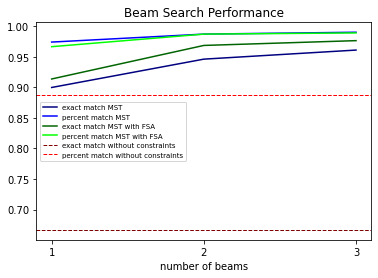

In [69]:

import matplotlib.pyplot as plt
nbs = list(range(1, 4))
plt.plot(nbs, [np.mean(x) for x in bs_mst_matches], label="exact match MST", color='navy')
plt.plot(nbs, [np.mean(x) for x in bs_mst_percent_matches], label="percent match MST", color='blue')
plt.plot(nbs, [np.mean(x) for x in bs_fsa_mst_matches], label="exact match MST with FSA", color='darkgreen')
plt.plot(nbs, [np.mean(x) for x in bs_fsa_mst_percent_matches], label="percent match MST with FSA", color='lime')
plt.axhline(y=np.mean(mst_matches), label="exact match without constraints", linewidth=1, linestyle='dashed', color='maroon')
plt.axhline(y=np.mean(mst_percent_matches), label="percent match without constraints", linewidth=1, linestyle='dashed', color='red')
plt.legend(loc="center left" ,prop={'size': 7})
plt.xlabel("number of beams")
plt.xticks(nbs)
plt.title("Beam Search Performance")